In [1]:
import pandas as pd


In [2]:
indicators = pd.read_csv('/content/1960_onwards.csv')
print(indicators.head())

   Year  Consumer price index (2010 = 100)  GDP (constant LCU)  \
0  1960                           0.065886        9.277980e+12   
1  1961                           0.070023        9.295770e+12   
2  1962                           0.073710        9.677180e+12   
3  1963                           0.071724        1.050730e+13   
4  1964                           0.072338        1.102750e+13   

   GDP (current LCU)  GDP growth (annual %)  GDP per capita (current US$)  \
0       2.997269e+09               0.191795                     93.397048   
1       3.190921e+09               0.191795                     97.420968   
2       3.506715e+09               4.102993                    104.852749   
3       3.689709e+09               8.578619                    108.015742   
4       3.966381e+09               4.950489                    113.658375   

   GDP per capita growth (annual %)  Inflation, GDP deflator (annual %)  \
0                         -1.834010                            6.

In [3]:
#Checking for missing data

indicators.isna().sum()

Year                                                        0
Consumer price index (2010 = 100)                           0
GDP (constant LCU)                                          0
GDP (current LCU)                                           0
GDP growth (annual %)                                       0
GDP per capita (current US$)                                0
GDP per capita growth (annual %)                            0
Inflation, GDP deflator (annual %)                          0
Inflation, consumer prices (annual %)                       0
Livestock production index (2014-2016 = 100)                0
Official exchange rate (LCU per US$, period average)        0
Total reserves (includes gold, current US$)                 0
Population, total                                           0
Population, female                                          0
Population, male                                            0
Population ages 0-14 (% of total population)                0
Populati

## Modelling

In [4]:

X = indicators.drop('GDP per capita (current US$)', axis =1)
y = indicators['GDP per capita (current US$)']

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import r2_score,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report,roc_auc_score,roc_curve,auc,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have your scaled data ready
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_train)

# Evaluate the model
r2_score = rf_reg.score(X_test_scaled, y_test)
print(f"R-squared: {r2_score:.2f}")

R-squared: 0.99


In [8]:
#Predictions and Evaluations
predict = rf_reg.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, predict)
rmse = mean_squared_error(y_test, predict, squared=False)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Mean Absolute Error: 54.12
Root Mean Squared Error: 81.98


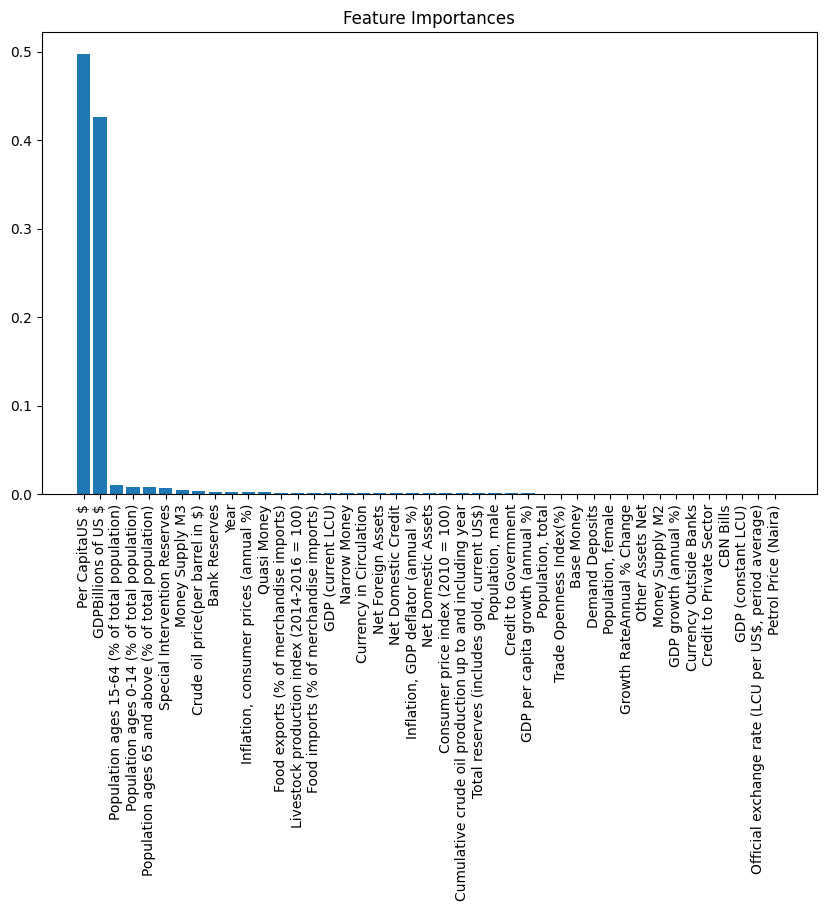

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Get the feature importances
importances = rf_reg.feature_importances_

# Sort the importances and get the feature names
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
feature_names = [X.columns[i] for i in sorted_idx]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importances)
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.title("Feature Importances")
plt.show()

## Cross Validation

In [10]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=2, min_samples_leaf=2)

# Create a 5-fold cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='r2')
print("Cross-validation R-squared scores:", scores)
print("Mean cross-validation R-squared score:", scores.mean())

Cross-validation R-squared scores: [0.98823775 0.99643093 0.99087686 0.97038625 0.96443633]
Mean cross-validation R-squared score: 0.982073624021712


## Hyperparameter Tuning using Gridsearch

In [11]:
# Create the base model
rf_model = RandomForestRegressor(random_state=42)

#Defining Parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gridsearch
grid_search = GridSearchCV(estimator=rf_model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='r2',
                          n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and the corresponding R-squared score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R-squared Score: {grid_search.best_score_:.2f}")


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best R-squared Score: 0.97


In [14]:
best_rf_reg = RandomForestRegressor(n_estimators=100,
                                   max_depth=5,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   random_state=42)


# Fit the model on the training data
best_rf_reg.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = best_rf_reg.predict(X_test_scaled)
error_score = r2_score(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R squared Error : , {error_score:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f" Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


R squared Error : , 99.31
Mean Absolute Error: 46.36
 Mean Squared Error: 5984.14
Root Mean Squared Error: 77.36


## Using filtered indicators - Random Forest

In [15]:
#Filtering Dataset
# Filter the dataframe to include only the specified columns
filtered_indicators = indicators[['GDP per capita (current US$)', 'Inflation, consumer prices (annual %)', 'Trade Openness Index(%)', 'Crude oil price(per barrel in $)', 'GDP (current LCU)', 'Population, total', 'Currency in Circulation', 'Year']]

# Exclude the year 2024 from the analysis
filtered_indicators = filtered_indicators[filtered_indicators['Year'] != 2024]
filtered_indicators = filtered_indicators.drop('Year',axis=1)
filtered_indicators.head()

,GDP per capita (current US$),"Inflation, consumer prices (annual %)",Trade Openness Index(%),Crude oil price(per barrel in $),GDP (current LCU),"Population, total",Currency in Circulation
0,93.397048,5.444327,26.16651,1.63,2.997269e+09,44928342,154.15
1,97.420968,6.279147,25.48501,1.57,3.190921e+09,45855507,160.19
2,104.852749,5.265632,21.82950,1.53,3.506715e+09,46821845,174.66
3,108.015742,-2.694655,22.31646,1.50,3.689709e+09,47822569,183.30
4,113.658375,0.856793,24.61532,1.45,3.966381e+09,48856332,214.71


In [16]:
#Correlation
corr = filtered_indicators.corr()
corr

,GDP per capita (current US$),"Inflation, consumer prices (annual %)",Trade Openness Index(%),Crude oil price(per barrel in $),GDP (current LCU),"Population, total",Currency in Circulation
GDP per capita (current US$),1.000000,-0.013040,0.090896,0.880464,0.701985,0.839050,0.754557
"Inflation, consumer prices (annual %)",-0.013040,1.000000,0.062562,-0.068040,-0.069162,0.051601,-0.082295
Trade Openness Index(%),0.090896,0.062562,1.000000,0.189518,-0.111686,0.120647,-0.047496
Crude oil price(per barrel in $),0.880464,-0.068040,0.189518,1.000000,0.721618,0.833021,0.783360
GDP (current LCU),0.701985,-0.069162,-0.111686,0.721618,1.000000,0.872385,0.985050
"Population, total",0.839050,0.051601,0.120647,0.833021,0.872385,1.000000,0.912067
Currency in Circulation,0.754557,-0.082295,-0.047496,0.783360,0.985050,0.912067,1.000000


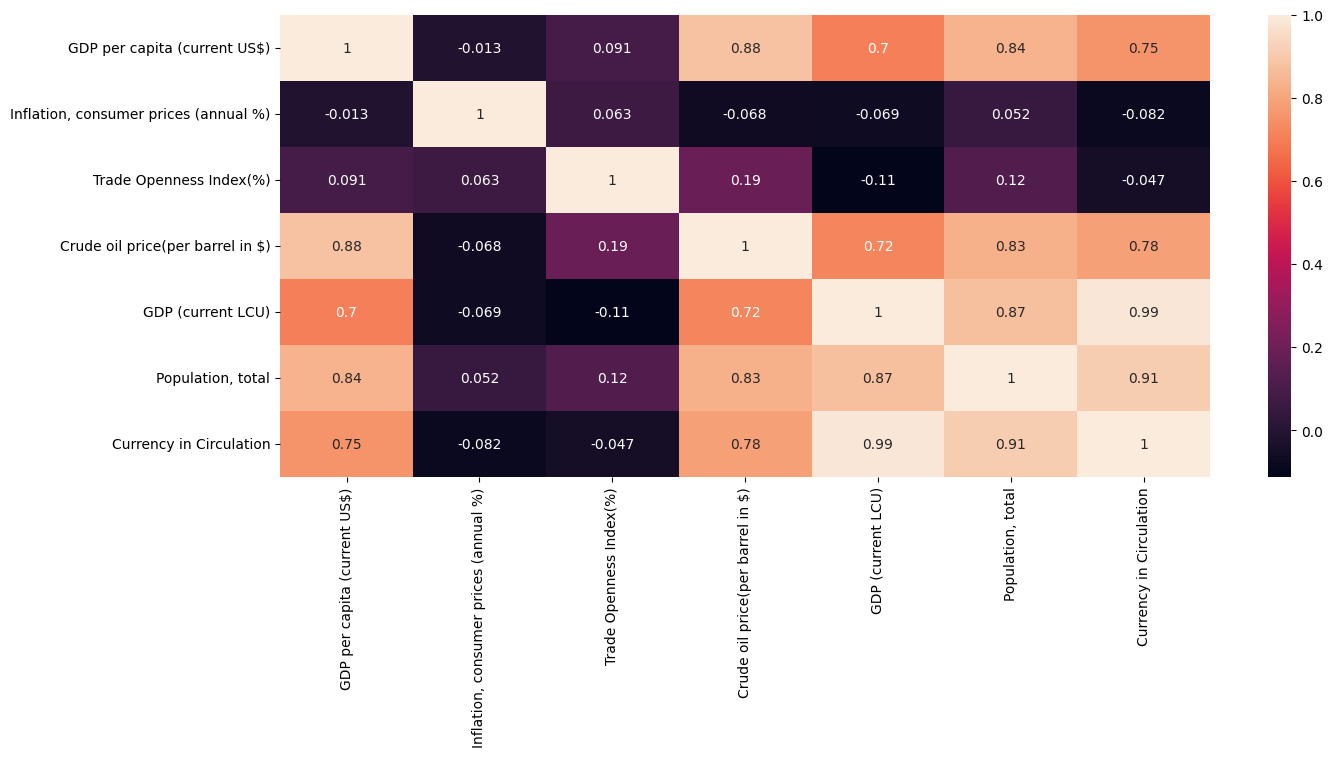

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
#Heatmap
sns.heatmap(corr, annot=True)
plt.show()

In [18]:
X = filtered_indicators.drop('GDP per capita (current US$)', axis =1)
y = filtered_indicators['GDP per capita (current US$)']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have your scaled data ready
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_train)

# Evaluate the model
r2_score = rf_reg.score(X_test_scaled, y_test)
print(f"R-squared: {r2_score:.2f}")

#Predictions and Evaluations
predict = rf_reg.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, predict)
rmse = mean_squared_error(y_test, predict, squared=False)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R-squared: 0.91
Mean Absolute Error: 168.79
Root Mean Squared Error: 271.17


In [21]:
#Cross-Validation
rf_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=2, min_samples_leaf=2)

# Create a 5-fold cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='r2')
print("Cross-validation R-squared scores:", scores)
print("Mean cross-validation R-squared score:", scores.mean())

Cross-validation R-squared scores: [0.92157043 0.94705229 0.85500186 0.66315415 0.85521711]
Mean cross-validation R-squared score: 0.8483991715415264


In [22]:
# Create the base model
rf_model = RandomForestRegressor(random_state=42)

#Defining Parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gridsearch
grid_search = GridSearchCV(estimator=rf_model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='r2',
                          n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and the corresponding R-squared score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R-squared Score: {grid_search.best_score_:.2f}")

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best R-squared Score: 0.77


In [25]:
best_rf_reg = RandomForestRegressor(n_estimators=200,
                                   max_depth=10,
                                   min_samples_split=2,
                                   min_samples_leaf=2,
                                   random_state=42)


# Fit the model on the training data
best_rf_reg.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = best_rf_reg.predict(X_test_scaled)
error_score = r2_score(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R squared Error : , {error_score:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f" Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

R squared Error : , 91.63
Mean Absolute Error: 170.33
 Mean Squared Error: 67066.39
Root Mean Squared Error: 258.97
